In [1]:
# imports

from __future__ import division
%config Completer.use_jedi = False
import os
print(os.getcwd())

import numpy as np
import torchaudio
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import torch
print(torch.__version__, torch.backends.cudnn.version(), torch.backends.cudnn.enabled)
#torch.backends.cudnn.benchmark = False
#torch.backends.cudnn.deterministic = True
#torch.autograd.set_detect_anomaly(True)
import asteroid

LOCATA=False
TEST=False

USE_24K=True

/home/ubuntu/proj/deepbeam
1.8.1+cu111 8005 True


In [2]:
%%html
<style type='text/css'>
.CodeMirror{
font-family: Consolas;
</style>

In [3]:
# path constants
vctk_path='../remote'
locata_path='../remote'
cache_path='../cache'
fs=48000
V=343

In [4]:
if LOCATA:
    import locata
    from locata import LocataDataset
    locata=LocataDataset('../remote/eval/', 'benchmark2', 48000, dev=True)

In [5]:
vctk=torchaudio.datasets.VCTK('../remote/')

In [6]:
print(len(vctk))
print(vctk[0][0].numpy()[0])
#print(len(locata))
#print(locata[0][1])

44070
[0.00485229 0.0067749  0.0062561  ... 0.00817871 0.00805664 0.00878906]


In [7]:
# gpu check
import torch.cuda as cutorch
for i in range(cutorch.device_count()):
     print(cutorch.get_device_properties(i))


import subprocess
from util import cudaMem


_CudaDeviceProperties(name='GeForce RTX 3090', major=8, minor=6, total_memory=24268MB, multi_processor_count=82)


In [8]:
# vctk audio check
import IPython.display as ipd
print(vctk[0])
ipd.Audio(vctk[0][0].numpy()[0], rate=fs)

(tensor([[0.0049, 0.0068, 0.0063,  ..., 0.0082, 0.0081, 0.0088]]), 48000, 'Please call Stella.\n', 'p225', '001')


In [9]:
# vctk adapter
class VCTKAudio:
    def __init__(self, vctk, numpy=True):
        self.vctk=vctk
        self.numpy=numpy
        
    def __getitem__(self, idx):
        return self.vctk[idx][0][0].numpy() if self.numpy else self.vctk[idx][0][0]
    
    def __len__(self):
        return len(self.vctk)

In [10]:
import librosa
class WHAM:
    def __init__(self, folder):
        self.folder=folder
        self.noisy_files=[]
        for file in os.listdir(folder):
            self.noisy_files.append(os.path.join(folder, file))
        np.random.shuffle(self.noisy_files)
    def __len__(self):
        return len(self.noisy_files)
    def __getitem__(self, idx):
        noise_audio, _ = librosa.load(self.noisy_files[idx], sr=fs, mono=True)
        return noise_audio

In [11]:
import torchaudio
class LibriSpeech:
    def __init__(self, folder):
        self.dataset=torchaudio.datasets.LIBRISPEECH(folder)
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        (waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id)=self.dataset[idx]
        return librosa.resample(waveform.numpy()[0], sample_rate, fs)

In [12]:
class MusDB18:
    def __init__(self, folder, duration, split=1):
        self.folder=folder
        self.duration=duration
        self.split=split
        self.mus_files=[]
        for file in os.listdir(folder):
            if os.path.isdir(os.path.join(folder, file)):
                self.mus_files.append(os.path.join(folder, file, 'mixture.wav'))
        np.random.shuffle(self.mus_files)
    def __len__(self):
        return len(self.mus_files)*self.split
    def __getitem__(self, idx):
        audio, _ = librosa.load(self.mus_files[idx//self.split], sr=fs, mono=True)
        mod=idx%self.split+1
        return audio[(len(audio)*mod//(self.split+1)):(len(audio)*mod//(self.split+1)+self.duration*fs)]

In [13]:
class RandomSubDataset:
    def __init__(self, dataset, num):
        self.dataset=dataset
        self.idx=np.random.choice(len(dataset), num, False)
    def __len__(self):
        return len(self.idx)
    def __getitem__(self, idx):
        return self.dataset[self.idx[idx]]
    
class FuseDataset:
    def __init__(self, *datasets):
        self.datasets=datasets
    
    def __len__(self):
        return sum([len(d) for d in self.datasets])
    
    def __getitem__(self, idx):
        for d in self.datasets:
            if len(d)>idx:
                return d[idx]
            else:
                idx-=len(d)
        
        return None

In [14]:
class RandomSet:
    def __init__(self, num, duration):
        self.data=np.random.rand(num, duration*fs)*2-1
    def __len__(self):
        return self.data.shape[0]
    def __getitem__(self, idx):
        return self.data[idx]

44070


<IPython.core.display.Javascript object>


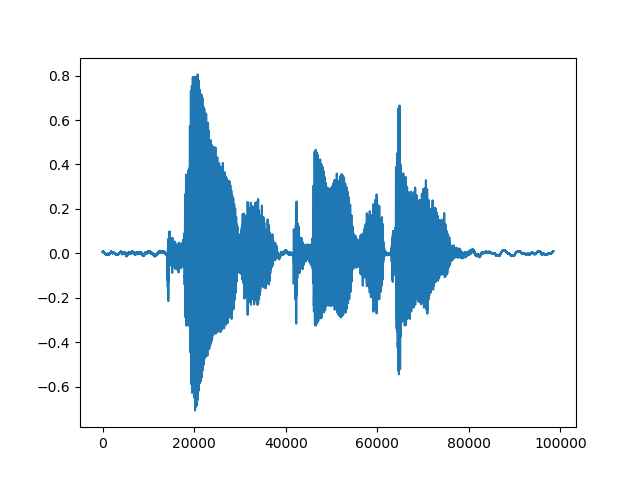

20000
200


<IPython.core.display.Javascript object>


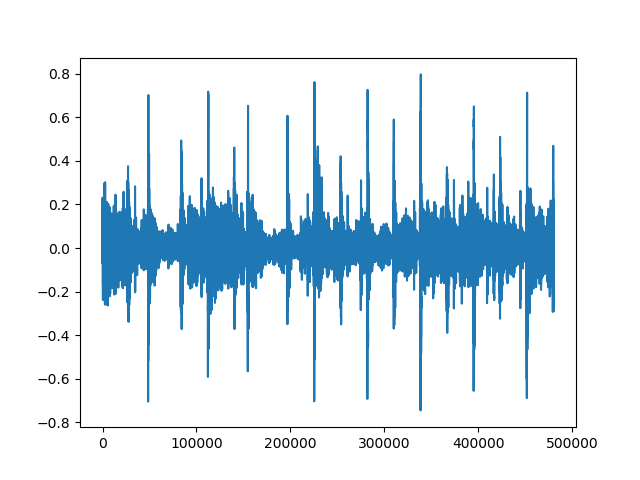

<IPython.core.display.Javascript object>


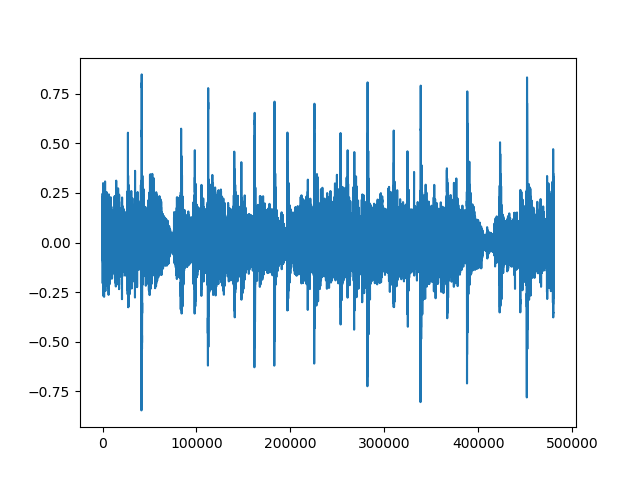

100


In [15]:
# test
vctk_audio=VCTKAudio(vctk)
print(len(vctk_audio))
plt.figure()
plt.plot(vctk_audio[0])

wham=WHAM('../remote/wham_noise/tr')
print(len(wham))

mus=MusDB18('../remote/musdb18/train', 10, 2)
print(len(mus))
plt.figure()
#ipd.display(ipd.Audio(mus[0], rate=fs))
plt.plot(mus[0])
plt.figure()
#ipd.display(ipd.Audio(mus[1], rate=fs))
plt.plot(mus[1])

randset=RandomSet(100, 5)
print(len(randset))


In [16]:
# locata audio test
if LOCATA:
    ipd.Audio(locata[0][0][:,0], rate=fs)

In [17]:
# MS dataset
import librosa
class MS_SNSD:
    def __init__(self, path, shuffle=True):
        noisy_wav_dir_path = [path+'/noise_test', path+'/noise_train']
        self.noisy_files = []
        for noisy_wav_dir in noisy_wav_dir_path:
            for file in os.listdir(noisy_wav_dir):
                if file.endswith('.wav'):
                    self.noisy_files.append(os.path.join(noisy_wav_dir, file))
        if shuffle:
            np.random.shuffle(self.noisy_files)
    def __len__(self):
        return len(self.noisy_files)
    def __read_audio(self,file):
        noise_audio, _ = librosa.load(file, sr=fs, mono=True)
        return noise_audio
    def __getitem__(self, idx):
        return self.__read_audio(self.noisy_files[idx])
    def get_batch(self, idx1, idx2):
        mic_sig_batch = []
        for idx in range(idx1, idx2):
            mic_sig_batch.append(self.__read_audio(self.noisy_files[idx]))
            
        return np.stack(mic_sig_batch)

In [18]:
ms_snsd=MS_SNSD('../remote/MS-SNSD')
print(len(ms_snsd))
ipd.Audio(ms_snsd[0], rate=fs)

179


In [19]:
# define datasets
noisesets=FuseDataset(ms_snsd, wham)
audiosets=vctk_audio

In [20]:
# acoustic property
N_MIC=6
R_MIC=0.06

max_rt60=0.3
max_room_dim=[10,10,4]
min_room_dim=[4,4,2]
min_dist=0.8 # dist between mic and person
min_gap=1.2 # gap between mic and walls

import pyroomacoustics as pra


def generate_mic_array(mic_radius: float, n_mics: int, pos):
    """
    Generate a list of Microphone objects
    Radius = 50th percentile of men Bitragion breadth
    (https://en.wikipedia.org/wiki/Human_head)
    """
    R = pra.circular_2D_array(center=[pos[0], pos[1]], M=n_mics, phi0=0, radius=mic_radius)
    R=np.concatenate((R, np.ones((1, n_mics))*pos[2]), axis=0)
    return R

# global mic array:
R_global=generate_mic_array(R_MIC, N_MIC, (0,0,0))

In [21]:
# simulate the room

def get_dist(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)

def get_angle(px, py):
    return np.arctan2(py, px)

def random2D(range_x, range_y, except_x, except_y, except_r, retry=100):
    if retry==0: return None
    if except_r<except_x<range_x-except_r and except_r<except_y<range_y-except_r:
        loc=(np.random.uniform(0, range_x), np.random.uniform(0, range_y))
        if get_dist(loc, (except_x, except_y))<except_r:
            return random2D(range_x, range_y, except_x, except_y, except_r, retry-1)
        else:
            return loc
    else:
        return None
        
def simulateRoom(N_source, min_room_dim, max_room_dim, min_gap, min_dist, min_angle_diff=0, retry=20):
    if retry==0: return None
    # return simulated room
    room_dim=[np.random.uniform(low, high) for low, high in zip(min_room_dim, max_room_dim)]
    R_loc=[np.random.uniform(min_gap, x-min_gap) for x in room_dim]
    source_locations=[random2D(room_dim[0], room_dim[1], R_loc[0], R_loc[1], min_dist) for i in range(N_source)]
    if None in source_locations: return None
    
    angles=[get_angle(p[0]-R_loc[0], p[1]-R_loc[1]) for p in source_locations]
    if N_source>1:
        min_angle_diff_rad=min_angle_diff*np.pi/180
        angles_sorted=np.sort(angles)
        if np.min(angles_sorted[1:]-angles_sorted[:-1])<min_angle_diff_rad or angles_sorted[0]-angles_sorted[-1]+2*np.pi<min_angle_diff_rad:
            return simulateRoom(N_source, min_room_dim, max_room_dim, min_gap, min_dist, min_angle_diff, retry-1)
    
    source_locations=[(x,y,R_loc[2]) for x,y in source_locations]
    
    return (room_dim, R_loc, source_locations, angles)

# Define materials
wall_materials = [
    'hard_surface',
    'brickwork',
    'rough_concrete',
    'unpainted_concrete',
    'rough_lime_wash',
    'smooth_brickwork_flush_pointing',
    'smooth_brickwork_10mm_pointing',
    'brick_wall_rough',
    'ceramic_tiles',
    'limestone_wall'
]
floor_materials = [
    'linoleum_on_concrete',
    'carpet_cotton',
    'carpet_tufted_9.5mm',
    'carpet_thin',
    'carpet_6mm_closed_cell_foam',
    'carpet_6mm_open_cell_foam',
    'carpet_tufted_9m',
    'felt_5mm',
    'carpet_soft_10mm',
    'carpet_hairy',
]

def simulateSound(room_dim, R_loc, source_locations, source_audios, rt60, materials=None, max_order=None):
    # source_audios: array of numpy array
    # L: max of all audios. Zero padding at the end
    # return (all_channel_data (C, L), groundtruth_with_reverb (N, C, L), groundtruth_data (N, C, L), angles (N)
    
    if materials is not None:
        (ceiling, east, west, north, south, floor)=materials
        room = pra.ShoeBox(
            room_dim,
            fs=fs,
            materials=pra.make_materials(
                ceiling=ceiling,
                floor=floor,
                east=east,
                west=west,
                north=north,
                south=south,
            ), max_order=max_order
        )
    else:
        try:
            e_absorption, max_order_rt60 = pra.inverse_sabine(rt60, room_dim)    
        except ValueError:
            e_absorption, max_order_rt60 = pra.inverse_sabine(1, room_dim)
        room=pra.ShoeBox(room_dim, fs=fs, materials=pra.Material(e_absorption), max_order=min(max_order_rt60, max_order))
        #room=pra.ShoeBox(room_dim, fs=fs, materials=pra.Material(e_absorption), max_order=0)
    
    R=generate_mic_array(R_MIC, N_MIC, R_loc)
    room.add_microphone_array(pra.MicrophoneArray(R, room.fs))
    
    length=max([len(source_audios[i]) for i in range(len(source_audios))])
    for i in range(len(source_audios)):
        source_audios[i]=np.pad(source_audios[i], (0, length-len(source_audios[i])), 'constant')
        
    
    for i in range(len(source_locations)):
        room.add_source(source_locations[i], signal=source_audios[i], delay=0)
    
    room.image_source_model()
    premix_w_reverb=room.simulate(return_premix=True)
    mixed=room.mic_array.signals
    
    # groundtruth
    room_gt=pra.ShoeBox(room_dim, fs=fs, materials=pra.Material(1.0), max_order=0)
    
    new_angles=np.zeros((len(source_locations),))
    
    R_gt=R[:, 0].reshape((3,1)) #generate_mic_array(0,1,R_loc)
    room_gt.add_microphone_array(pra.MicrophoneArray(R_gt, room.fs))
    
    for i in range(len(source_locations)):
        room_gt.add_source(source_locations[i], signal=source_audios[i], delay=0)
        new_angles[i]=get_angle(source_locations[i][0]-R_gt[0,0], source_locations[i][1]-R_gt[1,0])
    room_gt.compute_rir()
    
    room_gt.image_source_model()
    premix=room_gt.simulate(return_premix=True)
    
    return (mixed, premix_w_reverb, premix, new_angles)

def simulateBackground(background_audio):
    # diffused noise. simulate in a large room
    bg_radius = np.random.uniform(low=10.0, high=20.0)
    bg_theta = np.random.uniform(low=0, high=2 * np.pi)
    H=10
    bg_loc = [bg_radius * np.cos(bg_theta), bg_radius * np.sin(bg_theta), H]

    # Bg should be further away to be diffuse
    left_wall = np.random.uniform(low=-40, high=-20)
    right_wall = np.random.uniform(low=20, high=40)
    top_wall = np.random.uniform(low=20, high=40)
    bottom_wall = np.random.uniform(low=-40, high=-20)
    height = np.random.uniform(low=20, high=40)
    corners = np.array([[left_wall, bottom_wall], [left_wall, top_wall],
                    [   right_wall, top_wall], [right_wall, bottom_wall]]).T
    absorption = np.random.uniform(low=0.5, high=0.99)
    room = pra.Room.from_corners(corners,
                                 fs=fs,
                                 max_order=10,
                                 materials=pra.Material(absorption))
    room.extrude(height)
    mic_array = generate_mic_array(R_MIC, N_MIC, (0,0,H))
    room.add_microphone_array(pra.MicrophoneArray(mic_array, fs))
    room.add_source(bg_loc, signal=background_audio)

    room.image_source_model()
    room.simulate()
    return room.mic_array.signals


In [22]:
# test room simulation
if TEST:
    room_dim, R_loc, source_loc, angles=simulateRoom(3, (3,3,3), (10, 10,10), 1, 1, 10)
    fig=plt.figure()
    ax=fig.add_subplot(111, projection='3d')
    ax.scatter(room_dim[0], room_dim[1], room_dim[2], marker='o')
    ax.scatter(R_loc[0], R_loc[1], R_loc[2], marker='*')
    for x in source_loc:
        ax.scatter(x[0], x[1], x[2], marker='.')
    plt.show()
    print(room_dim, R_loc, source_loc, angles)

    mixed, premix_w_reverb, premix, _=simulateSound(room_dim, R_loc, source_loc, [np.random.randn(10000) for i in range(len(source_loc))], 0.3)

    print(mixed.shape, premix.shape, premix_w_reverb.shape)

    ceiling, east, west, north, south = tuple(np.random.choice(wall_materials, 5))  # sample material
    floor = np.random.choice(floor_materials)  # sample material
    mixed, premix_w_reverb, premix, _=simulateSound(room_dim, R_loc, source_loc, [np.random.randn(10000) for i in range(len(source_loc))], 0, (ceiling, east, west, north, south, floor), 5)

    print(mixed.shape, premix.shape, premix_w_reverb.shape)

In [23]:
# Audio simulation

from util import power, mix
from torch.utils.data import Dataset
import numpy as np
import pyroomacoustics as pra
import os


class OnlineSimulationDataset(Dataset):
    def __init__(self, voice_collection, noise_collection, length, simulation_config, truncator, cache_folder, cache_max=None):
        self.voices=voice_collection
        self.noises=noise_collection
        self.length=length
        self.seed=simulation_config['seed']
        self.additive_noise_min_snr=simulation_config['min_snr']
        self.additive_noise_max_snr=simulation_config['max_snr']
        self.special_noise_ratio=simulation_config['special_noise_ratio']
        self.source_dist=simulation_config['source_dist']
        self.min_angle_diff=simulation_config['min_angle_diff']
        self.max_rt60=simulation_config['max_rt60'] # 0.3s
        self.min_rt60=0.15 # minimum to satisfy room odometry
        self.max_room_dim=simulation_config['max_room_dim'] # [10,10,4]
        self.min_room_dim=simulation_config['min_room_dim'] #[4,4,2]
        self.min_dist=simulation_config['min_dist'] # 0.8, dist between mic and person
        self.min_gap=simulation_config['min_gap'] # 1.2, gap between mic and walls
        self.max_order=simulation_config['max_order']
        self.randomize_material_ratio=simulation_config['randomize_material_ratio']
        self.max_latency=simulation_config['max_latency']
        self.random_volume_range=simulation_config['random_volume_range'] # max and min volume ratio for sources
        
        self.low_volume_ratio=simulation_config['low_volume_ratio']
        self.low_volume_range=simulation_config['low_volume_range']
        self.angle_dev=simulation_config['angle_dev']
        
        self.no_reverb_ratio=simulation_config['no_reverb_ratio']
        
        self.truncator=truncator
        self.cache_folder=cache_folder
        self.cache_history=[]
        self.cache_max=cache_max
        
    def __seed_for_idx(self,idx):
        return self.seed+idx
    
    def __len__(self):
        return self.length
    def __getitem__(self, idx):
        # return format: 
        # (
        # mixed multichannel audio, (C,L)
        # array of groundtruth with reverb for each target, (N, C, L)
        # array of direction of targets, (N,)
        # array of multichannel ideal groundtruths for each target, (N, C, L)
        # noise (C, L)
        # )
        # check cache first
        
        if idx>=self.length:
            return None
        
        if self.cache_folder is not None:
            cache_path=self.cache_folder+'/'+str(idx)+'-'+str(self.seed)+'.npz'
            
            if cache_path not in self.cache_history:
                self.cache_history.append(cache_path)
            
                if self.cache_max is not None and self.cache_max==len(self.cache_history):
                    # delete first one
                    first=self.cache_history[0]
                    os.remove(first)
                    self.cache_history=self.cache_history[1:]
                
            if os.path.exists(cache_path):
                cache_result=np.load(cache_path, allow_pickle=True)['data']
                return cache_result[0], cache_result[1], cache_result[2], cache_result[3], cache_result[4]
        else:
            cache_path=None
        
        
        np.random.seed(self.__seed_for_idx(idx))
        n_source=np.random.choice(np.arange(len(self.source_dist)), p=self.source_dist)+1
        
        room_result=simulateRoom(n_source, self.min_room_dim, self.max_room_dim, self.min_gap, self.min_dist, self.min_angle_diff)
        if room_result is None:
            return self.__getitem__(idx+1) # backoff
            
        room_dim, R_loc, source_loc, source_angles=room_result
        
        voices=[self.truncator.process(self.voices[vi]) for vi in np.random.choice(len(self.voices), n_source)]
        
        # normalize voice
        voices=[v/np.max(np.abs(v)) for v in voices]
        
        voices=[v*np.random.uniform(self.random_volume_range[0], self.random_volume_range[1]) for v in voices]
        if np.random.rand()<self.low_volume_ratio:
            voices[0]*=np.random.uniform(self.low_volume_range[0], self.low_volume_range[1])
        
        if self.special_noise_ratio>np.random.rand():
            noise=self.truncator.process(self.noises[np.random.choice(len(self.noises))])
        else:
            noise=np.random.randn(self.truncator.get_length())

        no_reverb=(np.random.rand()<self.no_reverb_ratio)
        max_order=0 if no_reverb else self.max_order
        if self.randomize_material_ratio>np.random.rand():
            ceiling, east, west, north, south = tuple(np.random.choice(wall_materials, 5))  # sample material
            floor = np.random.choice(floor_materials)  # sample material
            mixed, premix_w_reverb, premix, new_angles=simulateSound(room_dim, R_loc, source_loc, voices, 0, (ceiling, east, west, north, south, floor), max_order)
        else:
            rt60=np.random.uniform(self.min_rt60, self.max_rt60)
            mixed, premix_w_reverb, premix, new_angles=simulateSound(room_dim, R_loc, source_loc, voices, rt60, None, max_order)
        
        
        background=simulateBackground(noise)
        snr=np.random.uniform(self.additive_noise_min_snr, self.additive_noise_max_snr)
        
        # trucate to the same length
        mixed=mixed[:, :truncator.get_length()]
        background=background[:, :truncator.get_length()]
        
        total, background=mix(mixed, background, snr)
        
        new_angles[0]+=(np.random.rand()*2-1)*self.angle_dev

        
        # save cache
        if cache_path is not None:
            np.savez_compressed(cache_path, data=[total, premix_w_reverb, new_angles, premix, background])
        
        return total, premix_w_reverb, new_angles, premix, background
        #return mixed, premix_w_reverb, source_angles, premix, background

In [24]:
# randomly truncate audio to fixed length

class RandomTruncate:
    def __init__(self, target_length, seed, power_threshold=None):
        self.length=target_length
        self.seed=seed
        self.power_threshold=power_threshold
        np.random.seed(seed)
    
    def process(self, audio):
        # if there is a threshold
        if self.power_threshold is not None:
            # smooth
            power=np.convolve(audio**2, np.ones((32,)), 'same')
            avgpower=np.mean(power)
            for i in range(len(power)):
                # threshold*mean_power
                if power[i]>avgpower*self.power_threshold:
                    #print(i, power[i], avgpower)
                    # leave ~=0.3s of start
                    fs=48000
                    audio=audio[max(0, i-int(0.3*fs)):]
                    break
        if len(audio)<self.length:
            nfront=np.random.randint(self.length-len(audio))
            return np.pad(audio, (nfront, self.length-len(audio)-nfront), 'constant')
        elif len(audio)==self.length:
            return audio
        else:
            start=np.random.randint(len(audio)-self.length)
            return audio[start:start+self.length]
        
    def get_length(self):
        return self.length
        

In [25]:
# test simulation dataset and truncate
simulation_config={
    'seed':3,
    'min_snr':5,
    'max_snr':25,
    'special_noise_ratio':0.9,
    'source_dist':[0.15, 0.4, 0.4, 0.05],
    'min_angle_diff':25,
    'max_rt60': 0.4,
    'max_room_dim':[7,7,4],
    'min_room_dim':[3,3,2],
    'min_dist': 0.8,
    'min_gap': 1.2,
    'max_order':8,
    'randomize_material_ratio':0.5,
    'max_latency':0.5,
    'random_volume_range': [0.7, 1],
    'low_volume_ratio': 0.04,
    'low_volume_range': [0.01, 0.02],
    'angle_dev': 0.09, # ~5 degree
    'no_reverb_ratio':0.005
}
truncator=RandomTruncate(3*fs, 5, 0.4)

# no cache for the original dataset
dataset=OnlineSimulationDataset(audiosets, noisesets, 4000, simulation_config, truncator, None)

<IPython.core.display.Javascript object>


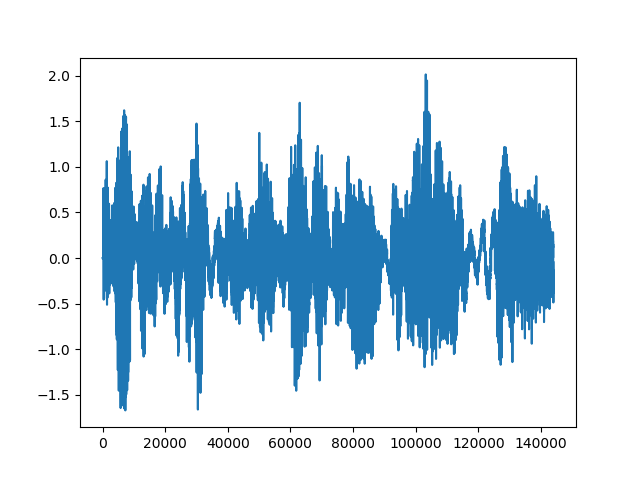

<IPython.core.display.Javascript object>


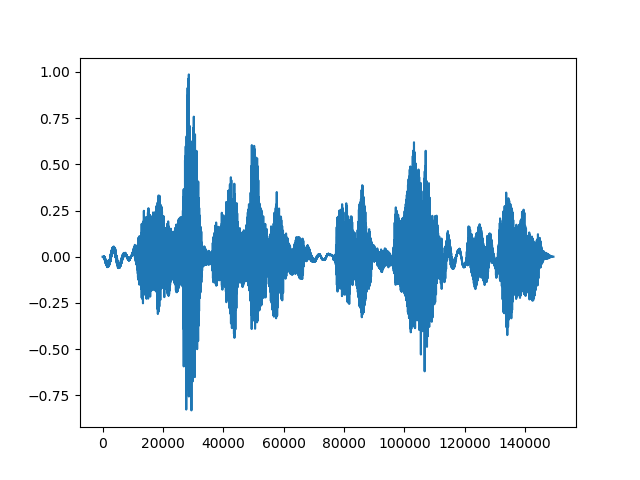

<IPython.core.display.Javascript object>


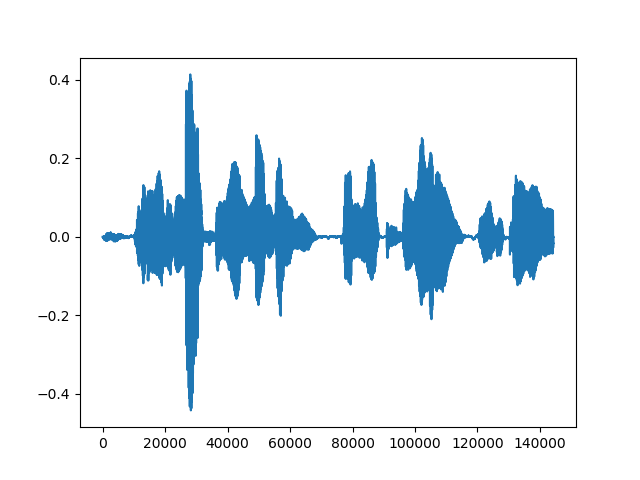

(6, 144000) (3, 6, 149440) (3, 1, 144312)
[-0.92567352  2.92584735  1.14765507]


In [26]:
# test one of them

total, premix_w_reverb, angles, premix, background=dataset[12]
plt.figure()
plt.plot(total[0])
plt.figure()
plt.plot(premix_w_reverb[0,0])
plt.figure()
plt.plot(premix[0,0])
print(total.shape, premix_w_reverb.shape, premix.shape)
print(angles)
#ipd.display(ipd.Audio(total, rate=48000))
#ipd.display(ipd.Audio(premix_w_reverb[1], rate=48000))
#ipd.display(ipd.Audio(premix[1], rate=48000))
#ipd.display(ipd.Audio(background, rate=48000))

[[ 6.00000000e-02  3.00000000e-02 -3.00000000e-02 -6.00000000e-02
  -3.00000000e-02  3.00000000e-02]
 [ 0.00000000e+00  5.19615242e-02  5.19615242e-02  7.34788079e-18
  -5.19615242e-02 -5.19615242e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


<IPython.core.display.Javascript object>


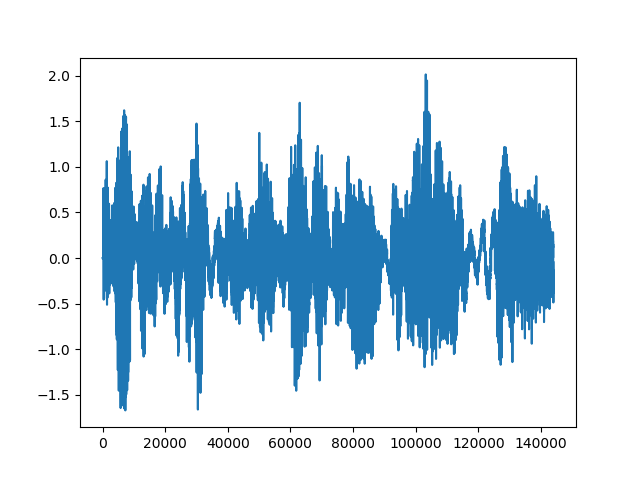

<IPython.core.display.Javascript object>


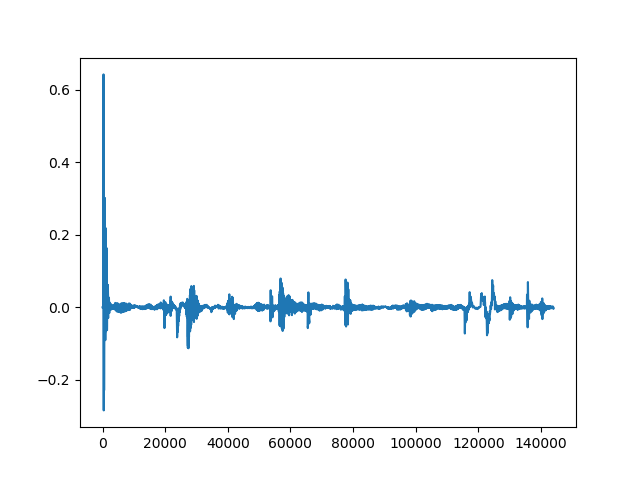

<IPython.core.display.Javascript object>


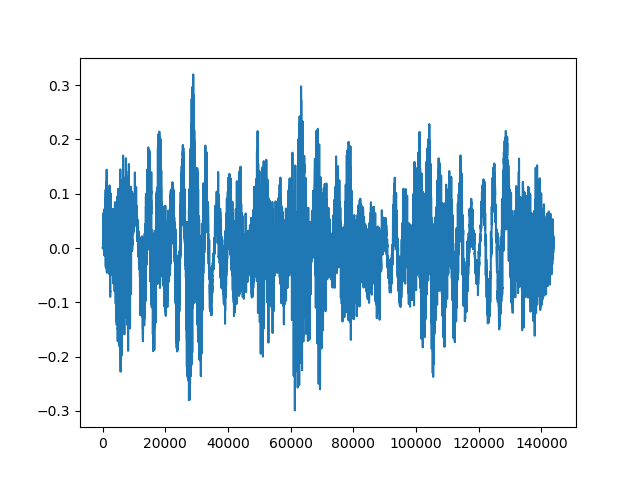

<IPython.core.display.Javascript object>


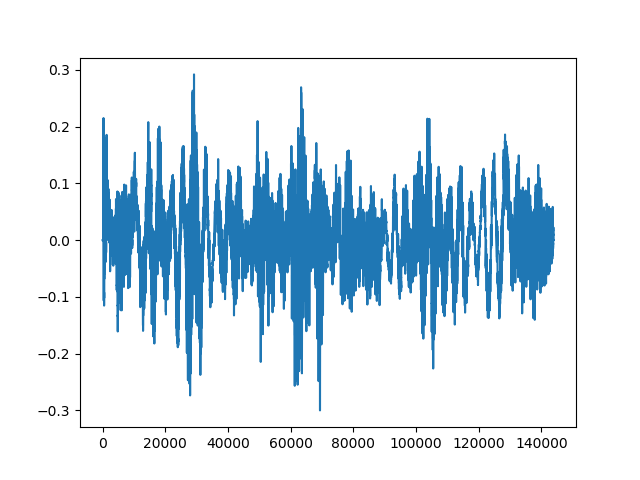

In [27]:
# beamformer test
import beamformer
import importlib
importlib.reload(beamformer)
from beamformer import WebrtcBeamformer, OnlineMVDRBeamformer
buffer_size_webrtc=256 # approx. 5ms
buffer_size_mvdr=256
webrtc_path='./beamform_mic_array'
#webrtc_path='../projects/webrtc_beamformer/deepbeam/beamform_mic_array'
#webrtc_path='/home/ubuntu/lib/beamform_mic_array'

beamformers=[WebrtcBeamformer(buffer_size_webrtc, R_global, fs, webrtc_path, cache_path), 
             OnlineMVDRBeamformer(buffer_size_mvdr, R_global, fs, V, False), # superdirective
             #OnlineMVDRBeamformer(buffer_size_mvdr, R_global, fs, V, True, False), # mvdr
             OnlineMVDRBeamformer(buffer_size_mvdr, R_global, fs, V, True, True, False) # online mvdr
             #OnlineMVDRBeamformer(buffer_size_mvdr, R_global, fs, V, False, False, True)
            ]

ipd.display(ipd.Audio(total, rate=48000))
plt.figure()
plt.plot(total[0])
#plt.plot(premix[0,0][:144000])
plt.show()
#ipd.display(ipd.Audio(total[0]-premix[0,0][:144000], rate=48000))

for bf in beamformers:
    newaudio=bf.process(total.T, angles[0])
    #ipd.display(ipd.Audio(newaudio, rate=48000))
    plt.figure()
    plt.plot(newaudio)
    plt.show()

In [28]:
if TEST:
    ang=1.28
    signal=beamformers[1].process(total.T, ang)
    plt.figure()
    plt.plot(premix[0].reshape((-1,))[:140000])
    plt.plot(signal[:140000])


In [29]:
# test webrtc beamformer

if TEST:

    from util import si_sdr
    xs=[]
    ys=[]

    def get_power(signal):
        return np.sum(signal**2)/signal.size
    for ang in np.arange(0, 2*np.pi, 0.05):
        if ang%0.5<0.05:
            print(ang)
        signal=beamformers[0].process(total.T, ang)
        xs.append(ang)
        ys.append(si_sdr(signal[:140000], premix[0].reshape((-1,))[:140000]))
        #ys.append(get_power(signal))

    plt.figure()
    plt.plot(xs,ys)
    plt.show()


In [30]:
if TEST:
    for ang in np.arange(-3, -2, 0.1):
        print(ang)
        signal=beamformers[0].process(total.T, ang)
        ipd.display(ipd.Audio(signal, rate=48000))

In [31]:
# test mvdr beamformer
if TEST:
    from util import si_sdr
    xs=[]
    ys=[]

    def get_power(signal):
        return np.sum(signal**2)/signal.size
    for ang in np.arange(0, 2*np.pi, 0.05):
        if ang%0.5<0.05:
            print(ang)
        signal=beamformers[1].process(total.T, ang)
        xs.append(ang)
        #ys.append(get_power(signal))
        ys.append(si_sdr(signal[:140000], premix[0].reshape((-1,))[:140000]))
    plt.figure()
    plt.plot(xs,ys)
    plt.show()


In [32]:
from util import alignChannel
from scipy.signal import resample
from scipy.signal import stft

def batchHalveSR(signals):
    if len(signals.shape)==2:
        n=signals.shape[0]
        result=np.zeros((n, signals.shape[1]//2))
        for i in range(n):
            result[i]=resample(signals[i], signals.shape[1]//2)
        return result
    else:
        result=np.stack([batchHalveSR(signals[i]) for i in range(signals.shape[0])], axis=0)

def transform_spec(signal, spec_window):
    _,_,res=stft(signal, nperseg=spec_window, noverlap=spec_window//2)
    return np.stack([np.real(res), np.imag(res)], axis=0)
        
class SimulationBeamformedDataset():
    def __init__(self, simulationDataset, beamformers, cache_folder, cache_max=None, align=False, return_spec=False, spec_window=32):
        self.beamformers=beamformers
        self.dataset=simulationDataset
        
        self.cache_folder=cache_folder
        self.cache_history=[]
        self.cache_max=cache_max
        self.align=align
        self.return_spec=return_spec
        self.spec_window=spec_window
        
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, idx):
        
        if self.cache_folder is not None:
            cache_path=self.cache_folder+'/sbd-'+str(idx)+'.npz'
            
            if cache_path not in self.cache_history:
                self.cache_history.append(cache_path)
            
                if self.cache_max is not None and self.cache_max==len(self.cache_history):
                    # delete first one
                    first=self.cache_history[0]
                    os.remove(first)
                    self.cache_history=self.cache_history[1:]
                
            if os.path.exists(cache_path):
                cache_result=np.load(cache_path, allow_pickle=True)['data']
                if self.return_spec:
                    spec=transform_spec(np.concatenate([cache_result[0], cache_result[1]], axis=0), self.spec_window)
                    return cache_result[0], cache_result[1], cache_result[2], cache_result[3], spec
                return cache_result[0], cache_result[1], cache_result[2], cache_result[3]
        else:
            cache_path=None
        
        total, premix_w_reverb, source_angles, premix, background=self.dataset[idx]
        # choose the first component
        bfdata=np.zeros((len(self.beamformers), total.shape[1]))
        for i in range(len(self.beamformers)):
            res=self.beamformers[i].process(total.T, source_angles[0])[:total.shape[1]]
            if len(res)<total.shape[1]: 
                bfdata[i]=np.pad(res, (0, total.shape[1]-len(res)), 'constant')
            else:
                bfdata[i]=res[:total.shape[1]]
        if self.align:
            total=alignChannel(total.T, source_angles[0], R_global-np.tile(R_global[:,0].reshape((3,1)), (1, N_MIC))).T
                
        # currently only need total, bfdata and premix
        gt=premix[0, :, :total.shape[1]]
        
        # resample
        if USE_24K:
            total=batchHalveSR(total)
            bfdata=batchHalveSR(bfdata)
            gt=batchHalveSR(gt)
        
        # save cache
        if cache_path is not None:
            np.savez_compressed(cache_path, data=[total, bfdata, gt, source_angles[0]])
        
        if return_spec:
            spec=transform_spec(np.concatenate([total, bfdata], axis=0), self.spec_window)
            return total, bfdata, gt, source_angles[0], spec
        return total, bfdata, gt, source_angles[0]
    
        #return total, bfdata, premix_w_reverb[0, :, :total.shape[1]], source_angles[0], premix[0, :, :total.shape[1]], background

In [33]:
import util
importlib.reload(util)
from util import si_sdr, calculate_gain

train_dataset=SimulationBeamformedDataset(dataset, beamformers, '../bf_cache', 4100, True, return_spec=True)

simulation_config_test={
    'seed':5,
    'min_snr':5,
    'max_snr':25,
    'special_noise_ratio':0.9,
    'source_dist':[0.15, 0.4, 0.4, 0.05],
    'min_angle_diff':25,
    'max_rt60': 0.4,
    'max_room_dim':[7,7,4],
    'min_room_dim':[3,3,2],
    'min_dist': 0.8,
    'min_gap': 1.2,
    'max_order':8,
    'randomize_material_ratio':0.5,
    'max_latency':0.5,
    'random_volume_range': [0.7, 1],
    'low_volume_ratio': 0.04,
    'low_volume_range': [0.01, 0.02],
    'angle_dev': 0.09, # ~5 degree
    'no_reverb_ratio':0.005
}
testset=OnlineSimulationDataset(vctk_audio, ms_snsd, 200, simulation_config_test, truncator, None)
test_dataset=SimulationBeamformedDataset(testset, beamformers, '../bf_cache_test', 600, True, return_spec=True)

N=3
gains=np.zeros((N, 3))
for i in range(N):
    total, bfdata, premix, angle, spec=train_dataset[i]
    print(total.shape, bfdata.shape, premix.shape)
    for j in range(len(bfdata)):
        bf=bfdata[j]
        gain, _,_=calculate_gain(premix[0], total[0], bf)
        gains[i, j]=gain
    #ipd.display(ipd.Audio(total[0], rate=24000))


(6, 72000) (3, 72000) (1, 72000)
(6, 72000) (3, 72000) (1, 72000)
(6, 72000) (3, 72000) (1, 72000)


In [34]:
ipd.display(ipd.Audio(train_dataset[13][1][2], rate=24000))

<IPython.core.display.Javascript object>


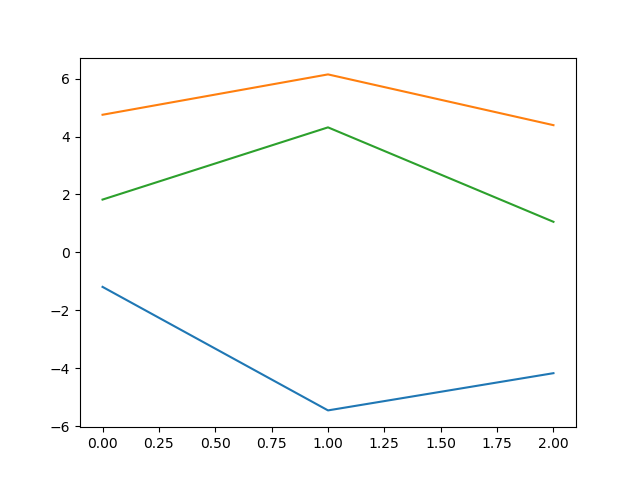

In [35]:
plt.figure()
for i in range(3):
    plt.plot(gains[:,i])
plt.show()

In [36]:
import gc
gc.collect()

16335

In [37]:
# simple model
import gc
import time
import model
importlib.reload(model)
from model import SimpleNetwork, NSNet, FuseModel

import torch
from torch import optim
from torch.optim.lr_scheduler import StepLR
import time

BATCH=5
batch_mul=4

HIGH_PROB=1.0
LOW_PROB=0.3

cuda_id=None


dataloader=torch.utils.data.DataLoader(train_dataset, batch_size=BATCH, shuffle=True, num_workers=4)
testloader=torch.utils.data.DataLoader(test_dataset, batch_size=BATCH, shuffle=False, num_workers=4)

def train_epoch(model, lossmodel, optimizer, scheduler, dataloader, save_path=None, last_loss=None):
    model.train()
    losses=[]
    tick0=time.time()
    high_cnt=0
    low_cnt=0
    
    optimizer.zero_grad()
    
    batch_losses=[]
    nan=False
    for batch_idx, (total, bfdata, premix, angles, spec) in enumerate(dataloader):
        tick1=time.time()
        data_all=torch.Tensor(spec.float())
        #data_all=torch.Tensor(np.concatenate([total, bfdata], axis=1))
        #data_all=torch.Tensor(total.float())
        data=data_all.cuda(cuda_id)
        premix_gpu=premix.cuda(cuda_id)
        tick2=time.time()
        #torch.cuda.synchronize()
        output=model(data)
        
        loss=lossmodel(output, premix_gpu).sum()
        l=loss.item()
        r=np.random.random()
        if (last_loss is None) or (l<last_loss and r<LOW_PROB) or (l>=last_loss and r<HIGH_PROB):
            loss.backward()
            if last_loss is not None and l<last_loss: 
                low_cnt+=1
            else: 
                high_cnt+=1
        
        
        tick3=time.time()
        batch_losses.append(l)
        if batch_idx%batch_mul==batch_mul-1:
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 2.)
            torch.nn.utils.clip_grad_value_(model.parameters(), 10)
            
            # check nan
            if not np.isnan(batch_losses).any():
                optimizer.step()
                print(sum(batch_losses))
            else:
                print("NaN loss, skip")
                nan=True
                break
            
            optimizer.zero_grad()
            batch_losses=[]
            
        
        data=None
        premix=None
        #, tick1-tick0, tick2-tick1, tick3-tick2, tick4-tick3)
        losses.append(l)
        
        # print()
        tick0=tick3
        
    scheduler.step()
    print("scheduler lr: ", scheduler.get_last_lr()[0])
    print("selective back: ", low_cnt, high_cnt)
    
    if save_path is not None:
        torch.save(model.state_dict(), save_path)
        print("saved")
    
    if not nan:
        return np.mean(losses)
    else:
        return None

def load_path(model, path):
    model.load_state_dict(torch.load(path))


In [39]:
#network=SimpleNetwork(10, 80, 16, 128, depth=4)
#network=NSNet(10, 128, 256, 1)
#network=FuseModel(10, 128, 64, 128, 16, 32, 288, 7, 7, 16, dilation=16, layers_crn=3, layers_1d=3)


#import model2
#importlib.reload(model2)
#from model2 import DualSRUModel, TestModel

import model4
importlib.reload(model4)
from model4 import SISDRLoss, L1Loss, FuseLoss

#import model6
#importlib.reload(model6)
#from model6 import BeamformerMaskModel, BeamformerModel

#import model7
#importlib.reload(model7)
#from model7 import BeamformerModel, BeamformerResModel, BeamformerEffModel, BeamformerRevModel

import modelfinal
importlib.reload(modelfinal)
from modelfinal import BeamformerModel

torch.manual_seed(3)
#network=DualModel(in_channels=9, spec_channels=32, block_size=144, first_kernel_size=(5,5), 
#                 lstm_kernel_size=5, lstm_channels=[32,16,8], lstm_layer=3, 
#                 reception=96, wav_channels=64, wav_layers=3, hidden_channels=80, wav_kernel_size=8)

#network=DualSRUModel(in_channels=9, spec_channels=48, block_size=144, first_kernel_size=(5,5), 
#                 lstm_num=8, lstm_channels=[8], lstm_layer=2, 
#                 reception=96, wav_channels=64, wav_layers=3, hidden_channels=80, wav_kernel_size=8)

#network=MiniBeamformerModel(in_channels=9, 
#                            spec_channels=16, 
#                            hidden_channels=48,
#                            out_channels=16,
#                            block_size=60, 
#                            layers=4, 
#                            freq_kernel_size=5, 
#                            time_kernel_size=4)

#network=MiniBeamformerModel(ch_in=9, ch=16, layers=5, block_size=60, time_kernel=3)

#network_ori=NaiveModel3(ch_in=6, ch_hidden=64, ch_mid=32, block_size=64)

#naivemodel=NaiveModel3(ch_in=6, ch_hidden=64, ch_mid=32, block_size=64)
#load_path(naivemodel, '../remote/trained/saved10.module.bin')
#network_ori=FuseModel(ch_in=6, ch_bf=3, ch_mid=64, ch_hid=96, k_reception=64, k_mid=4, naivemodel=naivemodel)

#network=HybridModel(ch_in=9, ch_raw=6, ch=8, ch_wav=64, ch_hid=96, blayers=1, players=1, block_size=60, wav_kernel=8, time_kernel=4, reception=64)

#network=BeamformerMaskModel(ch_in=6, chs=[64,48,32,24], freqs=[64,48,32,24], block_size=32, kernel=3, sub_layer=5)

#network=BeamformerModel(ch_in=6, chs=[64,32,24,16], freqs=[32,48,64], block_size=32, kernel=3, sub_layer=5)
#network=BeamformerModel(ch_in=6, ch_hidden=64, ch_mid=32, block_size=64, freqs=32)
#network=BeamformerResModel(ch_in=6, ch_hidden=64, ch_mid=32, block_size=64, freqs=32)
#network=BeamformerEffModel(ch_in=6, ch_hidden=64, ch_mid=32, block_size=64, freqs=32)
#network=BeamformerRevModel(ch_in=6, ch_hidden=64, ch_mid=32, block_size=64, ch_ext=16)

#network=MiniBeamformerModelV2(ch_in=6, ch=6, layers=4, block_size=60, time_kernel=4, ch_hid=36)
#loss_net=SISDRLoss(2400)


network=BeamformerModel(ch_in=6, ch_bf=3, ch_hid=64, ch_mid=32, synth_mid=64, synth_hid=128, block_size=32, freq=16, kernel=4, bf_layer=4, bf_rep=2, synth_layer=4, synth_rep=4)

loss_net=FuseLoss(2400, 10)

#network=FuseModel(in_channels=9,
#                  spec_channels=16, 
#                  hidden_channels=48, 
#                  out_channels=8, 
#                  block_size=60, 
#                  layers=4, 
#                  freq_kernel_size=5, 
#                  time_kernel_size=4, 
#                  wav_channels=64,
#                  wav_kernel=32)


#network=torch.nn.DataParallel(network_ori, device_ids=[0,1])
#loss_net=torch.nn.DataParallel(loss_net, device_ids=[0,1])

network=network.cuda(cuda_id)
loss_net=loss_net.cuda(cuda_id)

In [ ]:
#load_path(network, '../remote/trained/saved7.bin')
torch.save(network.module.state_dict(), '../remote/trained/saved10.module.bin')

In [49]:
lr=1e-4
lr_min=1e-4
decay=0.0
optimizer = optim.Adam(network.parameters(), lr=lr, weight_decay=decay)
scheduler = StepLR(optimizer, step_size=30, gamma=0.7)

from torch.optim.lr_scheduler import OneCycleLR
#scheduler=OneCycleLR(optimizer, max_lr=lr, total_steps=30)

from torch.optim.lr_scheduler import CosineAnnealingLR
#scheduler=CosineAnnealingLR(optimizer, T_max=15, eta_min=lr_min)

In [53]:
network.stage=0

In [46]:
from torchsummary import summary
#summary(network, (2, 9, 17, 151))

print(network(torch.zeros(2, 2, 9, 17, 151, device='cuda')).shape)

torch.Size([2, 1, 2400])


/usr/local/share/anaconda3/lib/python3.7/site-packages/torch/functional.py:655: UserWarning: istft will require a complex-valued input tensor in a future PyTorch release. Matching the output from stft with return_complex=True.  (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:787.)
  normalized, onesided, length, return_complex)


In [40]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(network))

1058916


In [ ]:
load_path(network, '../remote/trained/saved7.bin')
network.module.set_phase(1)
network=network.cuda(cuda_id)

In [ ]:
# prints currently alive Tensors and Variables
import torch
import gc
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            print(type(obj), obj.size())
    except:
        pass

In [41]:
# evaluate
def test_epoch(model, lossmodel, testloader):
    model.eval()
    gains=[]
    losses=[]
    inputgains=[]
    with torch.no_grad():
        for batch_idx, (total, bfdata, premix, angles, spec) in enumerate(testloader):
            data_all=torch.Tensor(spec.float())
            #data_all=torch.Tensor(np.concatenate([total, bfdata], axis=1))
            #data_all=torch.Tensor(total.float())
            data=data_all.cuda(cuda_id)
            premix_gpu=premix.cuda(cuda_id)
            
            output=model(data)
            
            loss=lossmodel(output, premix_gpu).sum()
            losses.append(loss.item())
            # test si-sdr
            output_cpu=output.cpu().detach().numpy()
            for i in range(output_cpu.shape[0]):
                if torch.max(premix[i,0])>0.02:
                    gain, _,_=calculate_gain(premix[i, 0, 24000:], total[i, 0,24000:], output_cpu[i, 0,24000:])
                    gains.append(gain)
                    #gain, _,_=calculate_gain(premix[i,0], total[i,0], torch.sum(total[i], dim=0))
                    gain, _,_=calculate_gain(premix[i,0], total[i,0], bfdata[i,2])
                    inputgains.append(gain)
            # print(gain)
    
    return losses, gains, inputgains

In [42]:
train_losses=[]
test_losses=[]

In [ ]:
from torch.utils.tensorboard import SummaryWriter
import torchvision

writer = SummaryWriter()
dummy=torch.ones(1, 10, 1440).cuda()
writer.add_graph(network, dummy)
writer.close()

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR
opt1=optim.AdamW(network.parameters(), lr=2e-4) # 2e-4
opt2=optim.AdamW(network.parameters(), lr=1.5e-3) # 2e-3
opt3=optim.AdamW(network.parameters(), lr=5e-4) # 5e-4

opts=[(opt1, StepLR(opt1, step_size=30, gamma=0.7), 2),
      (opt2, CosineAnnealingLR(opt2, T_max=8, eta_min=2e-4), 8),
      (opt3, StepLR(opt3, step_size=100, gamma=0.6), 100)]

for (opt, sch, n) in opts:
    for i in range(n):
        print("epoch "+str(len(train_losses)))
        last_loss=None
        #res=train_epoch(network, loss_net, opt, sch, dataloader, '../remote/trained/test.bin', last_loss)
        res=train_epoch(network, loss_net, opt, sch, dataloader, '../remote/trained/final_mid.bin', last_loss)
        #res=train_epoch(network, loss_net, opt, sch, dataloader, '../remote/trained/test_alt_32_64_16_rev.bin', last_loss)
        # saved4: naivemodel2
        # saved5: naivemodel3
        # saved6: naivemodel3
        # saved7: naivemodel3 first
        # saved7.1: naivemodel3 all
        # saved8: new naivemodel3 - 7.5dB
        # saved9: new naivemodel3 w/ cln and trelu and time conv - 7.4dB
        # saved10: new naivemodel3 w/ diff. freq shuffle and time conv - 10.5dB, 8dB realistically
        # saved11: new naivemodel3 w/ diff. freq shuffle and time conv, enlarged - 14.4dB, 12dB realistically
        # saved12: fine tuned, -16dB, 14.2dB realistically
        losses, gains, inputgains=test_epoch(network, loss_net, testloader)
        test_losses.append(np.mean(losses))
        print("avg: ", np.mean(losses), np.mean(gains), np.mean(inputgains))
        if res is not None:
            train_losses.append(res)
        else:
            break

        print("loss", res)

epoch 0


/usr/local/share/anaconda3/lib/python3.7/site-packages/torch/functional.py:655: UserWarning: istft will require a complex-valued input tensor in a future PyTorch release. Matching the output from stft with return_complex=True.  (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:787.)
  normalized, onesided, length, return_complex)


266.012647078045
246.03766889464842
252.42919882401912
234.0749469613616
233.98208110187994
245.98702088301187
244.54610261355097
232.97243566097484
229.742553795105
228.63025730423533
242.93260338644112
234.25981216400865
242.56314665240353
241.50504734945784
228.41244742426716
222.12498015438874
227.38928982365476
219.760836370901
205.57036828780474
221.4501696295671
216.93946350105423
220.25187353180146
201.23530183418347
212.74375629574658
195.4903808025694
189.11087623067147
190.3567408310488
177.21843099272698
182.19622824535662
175.55464941125857
172.96637762195323
172.63108406782777
165.13802179979345
158.79341764672685
137.96316538878108
147.5534188817297
162.27378680939765
143.8657726237298
149.93743644704927
154.49286809373694
151.31165362054963
153.32636432999792
137.76351853062212
132.5730507387964
144.89473913188738
154.2228333734122
152.4913441715233
140.20451050299403
129.89738607152222
127.34295922602774
117.59541516562442
129.3208450606212
125.00664066494451
124.26958

77.00715470286588
70.98068909282463
81.97406034676835
66.99698694151749
80.98134043702143
72.5537581349627
75.36773563755017
75.57644807077021
68.17347108202549
73.30603608386453
84.61318613228127
69.54513237506708
79.189984123395
67.30303148427632
75.1660219056367
56.50538366937619
75.80698673751456
60.19886485858632
70.79580344167091
51.846553921666484
71.05530460342511
78.44138448037515
75.41936560874831
65.88112699591957
62.92870725012103
76.51045197628206
67.54105501128005
70.21325241231858
65.74375165807041
65.31055890558791
65.70155112385173
66.16484279094811
61.20512426323667
69.37910847693115
83.91433130318366
73.03254542669978
81.02431911723566
78.00121688259749
65.60645594715618
81.67400949430848
72.01639418090403
85.23897960416305
66.54464153775476
69.00625027721567
76.88488992600713
68.20208230167852
85.96893101672202
64.54101408535266
70.40060761668036
70.63998363534954
74.33382718174337
92.0974041345279
81.90501128540348
81.0669386879622
85.37389540605588
78.958931314238

61.253413211647995
53.82225465861865
72.2093302059769
48.75531645159388
61.30491985717448
48.987115797000506
57.12587712423604
64.46957096936029
55.24057049068544
69.65842359249447
61.43687417862037
82.55042577794262
54.80825816852353
51.292169518769256
67.26765175778029
60.116140096404166
55.29309781572622
65.27822897228513
53.881322665810806
58.42108776858523
64.49516808295907
78.0335601615826
54.83308813522882
59.50708336778273
46.971784513480095
49.48601533367028
54.254151809508656
54.024761644000655
50.142645926238295
49.09538180677931
56.761032930851485
59.78854187855786
68.58303203386428
79.6774147388997
61.287944710030416
63.55448437529462
50.26435259417501
53.06999584831736
80.49957918514822
55.632060098070866
89.25014151087808
58.274217515447575
67.13496764460538
68.3530223412427
73.22638050262742
58.887283777906944
50.69836618144576
64.43079206724784
57.45388082230851
58.82119440239795
50.1761453304135
62.3453887522008
72.5883324487025
57.183037847350576
58.20643611765898
58

81.79665375640542
79.07181741869331
70.51619471198718
83.9112224186751
88.22545080513383
77.31303554497627
75.56329626683053
70.02359710305667
75.09455101262029
59.44600226838793
54.69957454440182
77.08394305791818
67.66414008718169
63.02979850943349
58.33269786868982
64.0919516529443
66.20236212921898
77.36795599815132
68.7424081262617
80.5438525400881
72.3164044461149
63.6563063081859
63.79653420422478
53.67397877880022
64.7159834594999
71.10916287013842
66.82762337307476
55.31857412556011
66.14138568642954
64.22287854116162
55.6571429808283
73.76283953021488
55.478221005143446
69.75714686401136
49.358211701568486
63.12207433252744
61.75210625980066
60.39198693558261
67.28539781354064
60.459262768509845
54.87698248506574
55.22417318858402
51.013847641695975
56.414381156452095
59.496037475744274
70.29654222292159
52.977187424005386
56.72719988318397
58.927078119215224
72.39684209026427
58.49641547612801
53.72768973902016
75.6219729420423
62.770946294351795
58.417012417675984
59.835941

56.24578587396652
49.933221259306
66.77304622463942
50.55757315575879
53.03860015023304
58.24799601442048
56.014236837808504
47.901158233339004
79.1823201755377
62.49862455092946
56.751352626220125
57.84101868183829
57.09654115223384
64.70738975154865
56.76895221265669
66.31768151457918
61.28555383742366
52.64945636111503
62.624189136501556
61.39039814370745
47.58242017378479
64.85101842727222
55.935716962863616
44.07743568112603
49.3869261856018
56.213995986051174
61.639404355680135
54.90155119084324
44.66707846336347
44.65348627043791
53.73863787250247
66.21420496282843
64.33952965000302
60.22076458990738
64.22958303233106
71.2688445259488
67.83836883484607
84.60481530197933
62.02795388903666
60.41242537523654
58.80121136899841
47.2507491646607
61.27153298686149
56.389447589380424
48.10006143415129
60.368158306080986
59.70087017871063
57.78168460803927
56.64972351950312
46.07562737933829
46.029884990802074
58.576320339792886
66.44770269037161
54.23720758866298
69.58881740234972
sched

In [50]:
for i in range(3):
    print("epoch "+str(i))
    last_loss=None # if i==0 else train_losses[-1]
    res=train_epoch(network, loss_net, optimizer, scheduler, dataloader, '../remote/trained/test_alt.bin', last_loss)
    losses, gains, inputgains=test_epoch(network, loss_net, testloader)
    test_losses.append(np.mean(losses))
    print("avg: ", np.mean(losses), np.mean(gains), np.mean(inputgains))
    if res is not None:
        train_losses.append(res)
    else:
        break
    
    print("loss", res)

epoch 0
10.612412189517087
15.07067601114754
10.530935397868987
13.345889620332228
13.02445111768509
14.484119616686908
10.638634553658385
10.621017702667851
13.066425616331884
14.862031733836282
14.647554391358373
10.719413758491536
10.463380898089712
7.260983481493819
9.337409038528783
18.18168243833507
14.924347991265051
10.149580704954145
9.292183906371491
6.634017855401429
11.541977757223886
9.29477721880173
6.46055898302936
14.906732832442515
13.990947765424758
11.067006156253793
7.513523393575646
9.230733658782635
9.282351850861906
14.560583557972329
15.942241093215136
11.59321898772238
12.206445223031562
14.1515470423603
10.512340933299917
19.53898457134372
18.17039538278543
13.777551030211566
9.857337290451555
14.128148127180602
12.144846539062325
8.197900963570966
13.627559628389122
7.388638095999346
11.455635460336849
11.656911166744743
11.629582418588868
6.555685762758024
10.20683423013961
11.49217346677888
13.07703752472478
8.776790083715007
15.630634657727292
13.241332556

16.658098133768515
10.10921607657378
9.999791774675998
10.509301562837466
13.799781181532602
12.091781763961874
12.077790273880165
11.063430860908115
5.208331944154471
11.002789884297446
14.133683767992533
10.203729572226583
14.041943902616662
15.652961993332731
15.216415778562808
11.321544611826443
13.15445657688809
11.561506924546984
13.910639652977103
11.65676289152984
12.56873314240013
12.440734371930585
10.859616532275188
9.273125173995558
7.608633115355136
9.615925112171581
14.092157911985712
13.025456073062564
12.017484473755285
17.39321006528054
9.88703746156545
7.618813784473312
10.167664481523522
12.371560394779232
11.69095171215525
9.764312565940523
10.434585174260718
11.287248706892491
11.8606381356236
8.973453921441745
13.411449165710707
10.966183275796066
8.117911587599512
11.791669922256602
11.890642831900553
14.943771631969916
12.727353815758342
12.894760216781549
10.688260623219122
13.191689055925565
12.515306900083107
10.427845562925906
9.76545725211517
7.281837347337

<IPython.core.display.Javascript object>


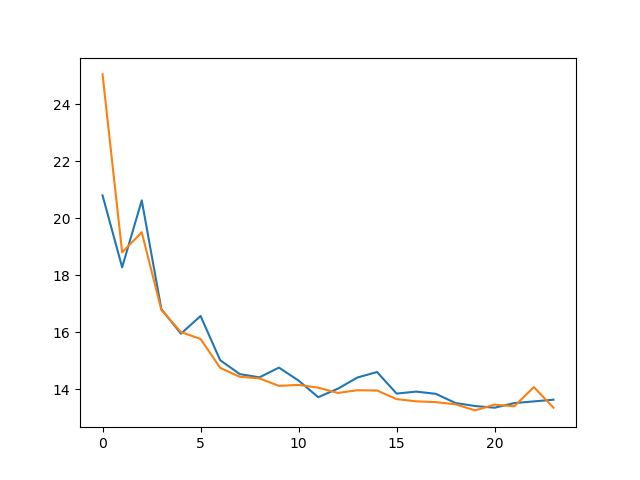

In [42]:
plt.figure()
#plt.plot(train_losses)
plt.plot(test_losses)
plt.plot(train_losses)

In [89]:
losses, gains, inputgains=test_epoch(network,loss_net, dataloader)
print("avg: ", np.mean(losses), np.mean(gains), np.mean(inputgains))

NameError: name 'test_epoch' is not defined

In [ ]:
# all metrics
from asteroid.metrics import get_metrics
from scipy.signal import resample

def resample2(sig):
    return resample(sig, sig.shape[-1]//3*2)

def test_metrics(model, testloader):
    model.eval()
    metrics=None
    with torch.no_grad():
        for batch_idx, (total, bfdata, premix, angles) in enumerate(testloader):
            data_all=torch.Tensor(np.concatenate([total, bfdata], axis=1))
            #data_all=torch.Tensor(total.float())
            data=data_all.cuda(cuda_id)
            premix_gpu=premix.cuda(cuda_id)
            
            output=model(data)
                        
            total_np=total.numpy()
            premix_np=premix.numpy()
            output_cpu=output.cpu().detach().numpy()
            
            for i in range(output_cpu.shape[0]):
                if torch.max(premix[i,0])>0.02:
                    m=get_metrics(resample2(total_np[i, 0]), resample2(premix_np[i, 0]), resample2(output_cpu[i, 0]), 8000)
                    if metrics is None:
                        metrics={x:[m[x]] for x in m}
                    else:
                        metrics={x:metrics[x]+[m[x]] for x in m}
            
            
    return {x:np.mean(metrics[x]) for x in metrics}

test_metrics(network, testloader)

In [73]:
load_path(network, '../remote/trained/test_alt_eff_trelu.bin')

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [75]:
def load_path_cpu(model, path):
    model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
load_path_cpu(network, '../remote/trained/test_alt_eff_trelu.bin')

In [ ]:
network.module.set_phase(1)
network=network.cuda(cuda_id)
load_path(network, '../remote/trained/saved7.1.bin')

In [ ]:
from complexcnn.modules import ComplexConv

## Parameters Below are totally random
input_channel = 3
output_channel = 24
kernel_size = (5,5)

complex_conv = ComplexConv(input_channel, output_channel, kernel_size)

d = complex_conv(torch.zeros(5, 2, 3, 5, 5))
print(d.shape)

In [ ]:
# listen test
def test_data(model, data):
    model.eval()
    with torch.no_grad():
        (total, bfdata, premix, angles)=data
        data_all=torch.Tensor(np.concatenate([total, bfdata], axis=1))
        #data_all=total.float()
        angles=torch.stack([
            torch.stack([torch.cos(angles), torch.cos(angles)], dim=-1), 
            torch.stack([torch.sin(angles), -torch.sin(angles)], dim=-1)
        ], dim=-1).float()
        angles=angles.cuda(cuda_id)
        data=data_all.cuda(cuda_id)
        premix_gpu=premix.cuda(cuda_id)
        #output=model(data, angles)
        output=model(data)
        
        output_cpu=output.cpu().detach().numpy()
        
    return total[:,0], bfdata[:,:], output_cpu[:,0], premix[:,0]

In [ ]:
id=1
ix=0
for batch in dataloader:
    ix+=1
    if ix==id:
        total, bfdata, output_cpu, premix=test_data(network, batch)
        break

i=0
print(torch.max(premix[i]))
print(calculate_gain(premix[i, 24000:], total[i, 24000:], output_cpu[i, 24000:]))
ipd.display(ipd.Audio(total[i], rate=24000))
ipd.display(ipd.Audio(premix[i], rate=24000))
ipd.display(ipd.Audio(bfdata[i,1], rate=24000))
ipd.display(ipd.Audio(bfdata[i,2], rate=24000))
ipd.display(ipd.Audio(output_cpu[i], rate=24000))

In [ ]:
def resample23(sig):
    return resample(sig, sig.shape[-1]//3)
ipd.display(ipd.Audio(resample23(output_cpu[i]), rate=8000))
get_metrics(resample23(total[i])*32768, resample23(output_cpu[i])*32768, resample23(premix[i])*32768, 8000)

In [61]:
def probe_result(model, data):
    def get_probe():
        def hook(model, input, output):
            amp=output[0,0,:,:,1200]**2+output[0,1,:,:,1200]**2
            print(amp)
        return hook

    model.eval()
    with torch.no_grad():
        (total, bfdata, premix, angles)=data
        data_all=torch.Tensor(np.concatenate([total, bfdata], axis=1))
        data_all=data_all.float()
        handle=network.bf[3].register_forward_hook(get_probe())
        data=data_all.cuda(cuda_id)
        
        output = model(data)
        handle.remove()
        
        return output.cpu().detach().numpy()

In [62]:
id=3
ix=0
for batch in dataloader:
    ix+=1
    if ix<=id:
        probe_result(network, batch)
    else:
        break

tensor([[3.4416e-01, 5.5476e-01, 3.6141e-01, 2.6552e-02, 8.4535e-01, 7.1573e-01,
         1.8391e-01, 1.2255e+00, 5.8762e-01, 9.7134e-01, 1.1054e+00, 8.2779e-03,
         7.0428e-02, 5.7390e-03, 7.2670e-02, 2.3104e-01, 2.9431e+00, 5.2628e-01,
         9.5193e-01, 7.2094e-02, 8.0508e-02, 3.4238e-01, 1.8468e-01, 1.2265e+00],
        [3.4752e-01, 4.3917e-01, 7.8485e-01, 1.3073e-01, 1.0391e+00, 8.2066e-02,
         3.6093e-01, 6.5412e-01, 2.8662e-02, 1.4442e+00, 1.2605e-01, 4.7894e-01,
         5.4709e-02, 1.8711e+00, 1.3779e+00, 2.8787e-01, 3.6353e+00, 5.0161e-01,
         1.0127e+00, 1.4858e+00, 1.6546e-01, 7.9974e-01, 1.1623e+00, 1.9874e+00],
        [8.5132e-01, 2.1244e+00, 9.6552e-01, 1.0296e+00, 7.2697e-01, 9.1097e-01,
         2.3768e-01, 4.9874e-01, 4.8513e-01, 1.8982e-01, 2.4080e+00, 4.6129e-01,
         9.8543e-01, 9.9185e-01, 6.3330e-01, 2.8193e-01, 8.3919e-01, 5.6973e-01,
         4.2531e-01, 8.6219e-01, 1.5295e-01, 7.1441e-01, 4.5282e-01, 5.9989e-01],
        [1.3431e-02, 1.97

tensor([[2.9121e-02, 2.9653e+00, 1.0004e+00, 3.3978e-01, 8.9054e-01, 1.4749e+00,
         1.2306e-02, 3.5019e-01, 1.7915e+00, 8.2463e-01, 3.5908e-01, 7.7150e-02,
         3.4650e-02, 5.0090e-01, 3.7433e-01, 1.3333e-01, 3.1486e+00, 1.3336e+00,
         9.0215e-01, 4.1006e-01, 7.4920e-01, 7.4414e-01, 9.8616e-01, 4.4840e-01],
        [7.2126e-01, 5.4389e-01, 6.2143e-05, 1.6753e-01, 2.7699e-02, 2.9400e-01,
         7.8559e-02, 2.2075e-01, 1.1646e+00, 6.0664e-01, 2.0079e-01, 9.3741e-03,
         7.0885e-02, 5.2416e-01, 1.3868e+00, 2.0219e-01, 1.0431e+00, 5.5965e-01,
         9.3599e-01, 4.0667e-01, 5.5971e-01, 2.5168e-01, 6.5027e-01, 4.8490e-01],
        [1.1371e+00, 3.6959e+00, 1.4403e+00, 1.4914e+00, 1.4072e+00, 1.6973e+00,
         3.5930e-01, 4.2205e-01, 8.2589e-01, 1.3863e+00, 2.7237e-01, 3.0715e-01,
         1.4974e+00, 2.5190e-01, 1.4060e-01, 2.2855e-01, 1.0355e+00, 2.1525e-01,
         1.2139e-01, 1.5757e-01, 3.7954e-01, 3.2684e-01, 5.1339e-02, 1.2670e-01],
        [5.0566e-01, 2.98

In [ ]:
def inspect_model(model):
    def rec(module):
        if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Conv1d):
            result=[]
            for (idx, l) in enumerate(module.weight):
                result.append((torch.sum(l**2).item(), idx))
            result.sort()
            m=result[-1][0]
            result=[(r/m, idx) for (r, idx) in result]
            return result
        else:
            result={}
            for n in module._modules:
                result[n]=rec(module._modules[n])
            return result
    return rec(model.module)

def probe_model(model, data):
    def gen_probe(name):
        def probe(model, input, output):
            # input: B, C, ...
            input=input[0]
            try:
                result=[]
                for ch in range(input.shape[1]):
                    result.append((torch.sum(input[:, ch]**2).item(), ch))
                result.sort()
                m=result[-1][0]
                result=[(r/m, idx) for (r, idx) in result]
                print((name, result))
            except Exception as e:
                print("error: ", e)
        return probe
        
    def add_hook(name, module):
        if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Conv1d):
            return [module.register_forward_hook(gen_probe(name))]
        else:
            result=[]
            for n in module._modules:
                result+=add_hook(name+"."+n, module._modules[n])
            return result
        
    hooks=add_hook("root", model.module)
    model.eval()
    with torch.no_grad():
        (total, bfdata, premix, angles)=data
        data_all=torch.Tensor(np.concatenate([total, bfdata], axis=1))
        #data_all=total.float()
        data=data_all.cuda(cuda_id)
        output = model(data)
        
        for hook in hooks:
            hook.remove()
        
inspect_model(network)

for batch in dataloader:
    probe_model(network, batch)
    break
    

In [ ]:
plt.figure()
plt.plot(total[0])
plt.figure()
plt.plot(output_cpu[0])
plt.figure()
plt.plot(premix[0])
plt.show()

In [ ]:
from scipy.io import wavfile
wavfile.write('/homes/iws/anranw/demo_res4.wav', 48000, output_cpu[0])
wavfile.write('/homes/iws/anranw/demo_ori4.wav', 48000, total[0].numpy())

In [ ]:
plt.figure()
plt.plot(output_cpu[i]) #/max(output_cpu[i]))
plt.plot(bfdata[i,2]/max(bfdata[i,2]))
plt.plot(batch[2][i][0].numpy()/max(batch[2][i][0].numpy()))

In [ ]:
from util import real_bpf
wind=real_bpf(24000, 100, 4000, 128)
filtered_cpu=np.real(np.convolve(output_cpu[i], wind, 'valid'))
ipd.display(ipd.Audio(filtered_cpu, rate=24000))

In [ ]:
for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
# test delay
import util
importlib.reload(util)
from util import alignChannel

TEST=True

if TEST:
    total, premix_w_reverb, angles, premix, background=dataset[4]
    from util import si_sdr
    xs=[]
    ys=[]
    
    for ang in np.arange(0, 2*np.pi, 0.2):
        if ang%1<0.01:
            print(ang)
        aligned=alignChannel(total.T, ang, R_global-np.tile(R_global[:,0].reshape((3,1)), (1, N_MIC))).sum(axis=-1)
        
        xs.append(ang)
        ys.append(si_sdr(aligned[:140000], premix[0].reshape((-1,))[:140000]))
        
    plt.figure()
    plt.plot(xs, ys)

In [ ]:
import util
importlib.reload(util)
from util import alignChannel

total, premix_w_reverb, angles, premix, background=dataset[4]
aligned=alignChannel(total.T, angles[0], R_global-np.tile(R_global[:,0].reshape((3,1)), (1, N_MIC))).sum(axis=-1)
bf=WebrtcBeamformer(buffer_size_webrtc, R_global, fs, webrtc_path, cache_path) #OnlineMVDRBeamformer(buffer_size_mvdr, R_global, fs, V, False)
cmp=bf.process(total.T, angles[0])
plt.figure()
plt.plot(aligned/np.max(np.abs(aligned)))
plt.plot(cmp)
plt.plot(premix[0].reshape((-1,))/np.max(np.abs(premix[0])))


In [ ]:
print(len(train_dataset), len(test_dataset))
for i in range(len(train_dataset)):
    x=train_dataset[i]
    if np.isnan(x[1]).any() or np.isinf(x[1]).any():
        print(i)

print("test")
        
for i in range(len(test_dataset)):
    x=test_dataset[i]
    if np.isnan(x[1]).any() or np.isinf(x[1]).any():
        print(i)


In [39]:
gains=[]
for i in range(len(test_dataset)):
    total, bfdata, premix, angles=test_dataset[i]
    gain, _,_=calculate_gain(premix[0], total[0], bfdata[2])
    gains.append(gain)
print(np.mean(gains))

6.157101577179971


In [ ]:
# test cLog and cExp
import complexcnn.modules
importlib.reload(complexcnn.modules)
from complexcnn.modules import cLog, cExp
a=torch.ones(3,2,4)
print(cLog(cExp(a)))

In [ ]:
# check sru
import torch
from sru import SRU, SRUCell

# input has length 20, batch size 2 and dimension 128
x = torch.FloatTensor(2, 100, 1000).cuda()

input_size, hidden_size = 100, 101

rnn = SRU(input_size, hidden_size,
    num_layers = 1,          # number of stacking RNN layers
    dropout = 0.0,           # dropout applied between RNN layers
    bidirectional = False,   # bidirectional RNN
    layer_norm = False,      # apply layer normalization on the output of each layer
    highway_bias = 0,        # initial bias of highway gate (<= 0)
    rescale = True 
)
rnn.cuda()

output_states, c_states = rnn(x.permute(2,0,1))# forward pass
print(output_states.shape)
output_states.sum().backward()

In [ ]:
# check parameters
state=network.state_dict()
for k in state:
    print(k, torch.isnan(state[k]).any())
    #if not torch.isnan(state[k]).any():
    #    print(state[k])

In [38]:
for batch_idx, (total, bfdata, premix, angles) in enumerate(dataloader):
    print(batch_idx)
    pass
for batch_idx, (total, bfdata, premix, angles) in enumerate(testloader):
    print(batch_idx)
    pass

/home/ubuntu/proj/deepbeam/util.py:157: ComplexWarning: Casting complex values to real discards the imaginary part
  result[:,m]=delay(signal[:,m], d)
/home/ubuntu/proj/deepbeam/util.py:157: ComplexWarning: Casting complex values to real discards the imaginary part
  result[:,m]=delay(signal[:,m], d)
/home/ubuntu/proj/deepbeam/util.py:157: ComplexWarning: Casting complex values to real discards the imaginary part
  result[:,m]=delay(signal[:,m], d)
/home/ubuntu/proj/deepbeam/util.py:157: ComplexWarning: Casting complex values to real discards the imaginary part
  result[:,m]=delay(signal[:,m], d)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/home/ubuntu/proj/deepbeam/util.py:157: ComplexWarning: Casting complex values to real discards the imaginary part
  result[:,m]=delay(signal[:,m], d)
/home/ubuntu/proj/deepbeam/util.py:157: ComplexWarning: Casting complex values to real discards the imaginary part
  result[:,m]=delay(signal[:,m], d)
/home/ubuntu/proj/deepbeam/util.py:157: ComplexWarning: Casting complex values to real discards the imaginary part
  result[:,m]=delay(signal[:,m], d)
/home/ubuntu/proj/deepbeam/util.py:157: ComplexWarning: Casting complex values to real discards the imaginary part
  result[:,m]=delay(signal[:,m], d)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [ ]:
#%% test datasets
import librosa
sig=librosa.load('../remote/wham_noise/tt/447o030w_1.9272_420c0203_-1.9272.wav', sr=48000, mono=True)[0]

ipd.display(ipd.Audio('../remote/wham_noise/tt/447o030w_1.9272_420c0203_-1.9272.wav', rate=16000))
ipd.display(ipd.Audio(sig, rate=48000))

In [ ]:
ipd.display(ipd.Audio('../remote/musdb18/train/Wall Of Death - Femme/mixture.wav', rate=16000))

In [ ]:
import torchaudio
dataset=torchaudio.datasets.LIBRISPEECH('../remote/')
(waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id)=dataset[0]
ipd.display(ipd.Audio(waveform, rate=sample_rate))
print(sample_rate)

In [32]:
# testset by num of sources
config_test={
    'seed':5,
    'min_snr':5,
    'max_snr':25,
    'special_noise_ratio':0.9,
    'min_angle_diff':25,
    'max_rt60': 0.4,
    'max_room_dim':[7,7,4],
    'min_room_dim':[3,3,2],
    'min_dist': 0.8,
    'min_gap': 1.2,
    'max_order':8,
    'randomize_material_ratio':0.5,
    'max_latency':0.5,
    'random_volume_range': [0.7, 1],
    'low_volume_ratio': 0.04,
    'low_volume_range': [0.01, 0.02],
    'angle_dev': 0.09, # ~5 degree
    'no_reverb_ratio':0.005
}

for i in range(1, 4):
    config_test['source_dist']=[0,0,0,0]
    config_test['source_dist'][i]=1
    testseti=OnlineSimulationDataset(vctk_audio, ms_snsd, 200, config_test.copy(), truncator, None)
    test_dataseti=SimulationBeamformedDataset(testseti, beamformers, '../bf_cache_test_'+str(i+1), 600, True)
    testloaderi=torch.utils.data.DataLoader(test_dataseti, batch_size=4, shuffle=False, num_workers=2)
    for batch_idx, (total, bfdata, premix, angles) in enumerate(testloaderi):
        print(batch_idx)
        pass



/home/ubuntu/proj/deepbeam/util.py:157: ComplexWarning: Casting complex values to real discards the imaginary part
  result[:,m]=delay(signal[:,m], d)
/home/ubuntu/proj/deepbeam/util.py:157: ComplexWarning: Casting complex values to real discards the imaginary part
  result[:,m]=delay(signal[:,m], d)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


/home/ubuntu/proj/deepbeam/util.py:157: ComplexWarning: Casting complex values to real discards the imaginary part
  result[:,m]=delay(signal[:,m], d)
/home/ubuntu/proj/deepbeam/util.py:157: ComplexWarning: Casting complex values to real discards the imaginary part
  result[:,m]=delay(signal[:,m], d)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


/home/ubuntu/proj/deepbeam/util.py:157: ComplexWarning: Casting complex values to real discards the imaginary part
  result[:,m]=delay(signal[:,m], d)
/home/ubuntu/proj/deepbeam/util.py:157: ComplexWarning: Casting complex values to real discards the imaginary part
  result[:,m]=delay(signal[:,m], d)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [77]:
# evaluate
def test_epoch_cpu(model, lossmodel, testloader):
    model.eval()
    gains=[]
    losses=[]
    inputgains=[]
    with torch.no_grad():
        for batch_idx, (total, bfdata, premix, angles) in enumerate(testloader):
            #data_all=torch.Tensor(np.concatenate([total, bfdata], axis=1))
            data_all=torch.Tensor(total.float())
            #data=data_all.cuda(cuda_id)
            #premix_gpu=premix.cuda(cuda_id)
            
            output=model(data_all)
            
            loss=lossmodel(output, premix).sum()
            losses.append(loss.item())
            # test si-sdr
            output_cpu=output.cpu().detach().numpy()
            for i in range(output_cpu.shape[0]):
                if torch.max(premix[i,0])>0.02:
                    gain, _,_=calculate_gain(premix[i, 0, 24000:], total[i, 0,24000:], output_cpu[i, 0,24000:])
                    gains.append(gain)
                    #gain, _,_=calculate_gain(premix[i,0], total[i,0], torch.sum(total[i], dim=0))
                    gain, _,_=calculate_gain(premix[i,0], total[i,0], bfdata[i,2])
                    inputgains.append(gain)
            # print(gain)
    
    return losses, gains, inputgains

In [78]:
for i in range(4):
    config_test['source_dist']=[0,0,0,0]
    config_test['source_dist'][i]=1
    testseti=OnlineSimulationDataset(vctk_audio, ms_snsd, 200, config_test.copy(), truncator, None)
    test_dataseti=SimulationBeamformedDataset(testseti, beamformers, '../bf_cache_test_'+str(i+1), 600, True)
    testloaderi=torch.utils.data.DataLoader(test_dataseti, batch_size=4, shuffle=False, num_workers=2)
    losses, gains, inputgains=test_epoch_cpu(network, loss_net, testloaderi)
    print(i, np.mean(gains), np.mean(inputgains))

/usr/local/share/anaconda3/lib/python3.7/site-packages/torch/functional.py:655: UserWarning: istft will require a complex-valued input tensor in a future PyTorch release. Matching the output from stft with return_complex=True.  (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:787.)
  normalized, onesided, length, return_complex)


0 5.647254900289016 2.961700287014052
1 7.50882128518172 5.677548145057011
2 8.05670469764406 6.508019540658445
3 6.921957839523609 6.87123416718105


In [41]:
# ONNX
import torch.onnx
x = torch.randn(1,2,9,17,151)
network.eval()
network.stage=3
torch_out = network(x)

# Export the model
torch.onnx.export(network,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "model_high.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=13,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

In [52]:
from scipy.signal import stft
test=np.random.randn(3, 6, 64)
_,_,res=stft(test, nperseg=32, noverlap=16)
print(res.shape)
print(np.stack([np.real(res), np.imag(res)], axis=0).shape)

(3, 6, 17, 5)
(2, 3, 6, 17, 5)


In [42]:
from pytorch2keras import pytorch_to_keras
k_model = pytorch_to_keras(network, torch.randn(1,2,9,17,151), [(2,9,17,151,)], verbose=True) 

ImportError: cannot import name 'optimizer' from 'onnx' (/usr/local/share/anaconda3/lib/python3.7/site-packages/onnx/__init__.py)